# DeepMind Paper Implementation

- delete models
- huggingface-cli delete-cache

- Models used 124M, 774M: [https://huggingface.co/MBZUAI/LaMini-GPT-124M]
- 

In [1]:
import torch
import sentencepiece
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_draft = "MBZUAI/LaMini-GPT-124M" 
checkpoint_target = "MBZUAI/LaMini-GPT-774M"
# draft_model = pipeline('text-generation', model = checkpoint_draft)
# target_model = pipeline('text-generation', model = checkpoint_target)
draft_model = AutoModelForCausalLM.from_pretrained(checkpoint_draft).to(device)
target_model = AutoModelForCausalLM.from_pretrained(checkpoint_target).to(device)

## Algorithm 1: ArS

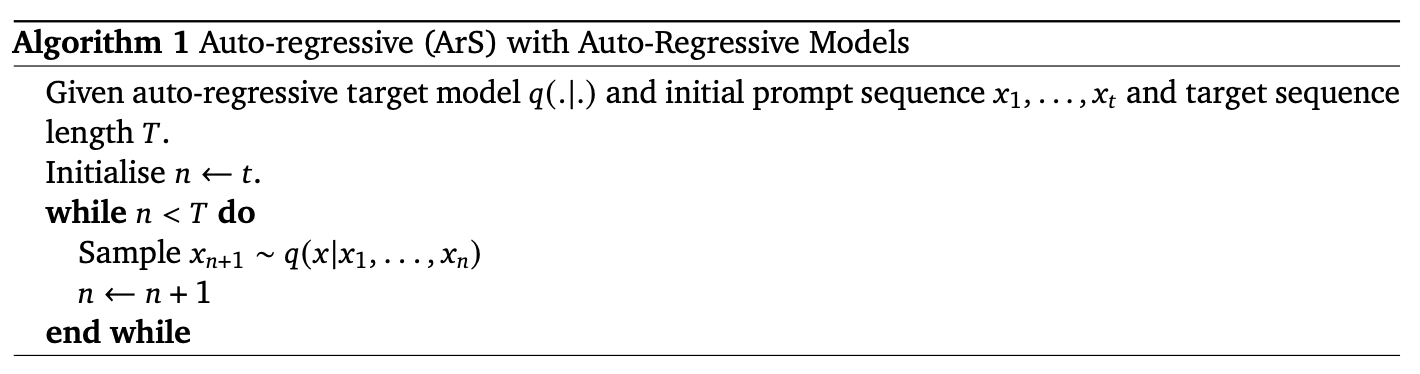

In [3]:
def sampling(p):
    output = torch.multinomial(p, 1)
    return output.reshape(1,-1)

' x is the tokenized prompt, max_new_tokens = N'
def autoregressive_generation(x, model, max_new_tokens=50):
    n = len(x)
    N = max_new_tokens
    T = len(x) + N
    # print(x)
    # print('x:',x.size() )
    while n<T:
        # print(n)
        logits = model_fn(model,x)
        # print('logits', logits.size())
        output = sampling(logits)
        # print('output:',output.size())
        # print(output)
        x = torch.cat((x, output), dim=-1)
        # print('x after cat', x.size())
        n += 1
    return x

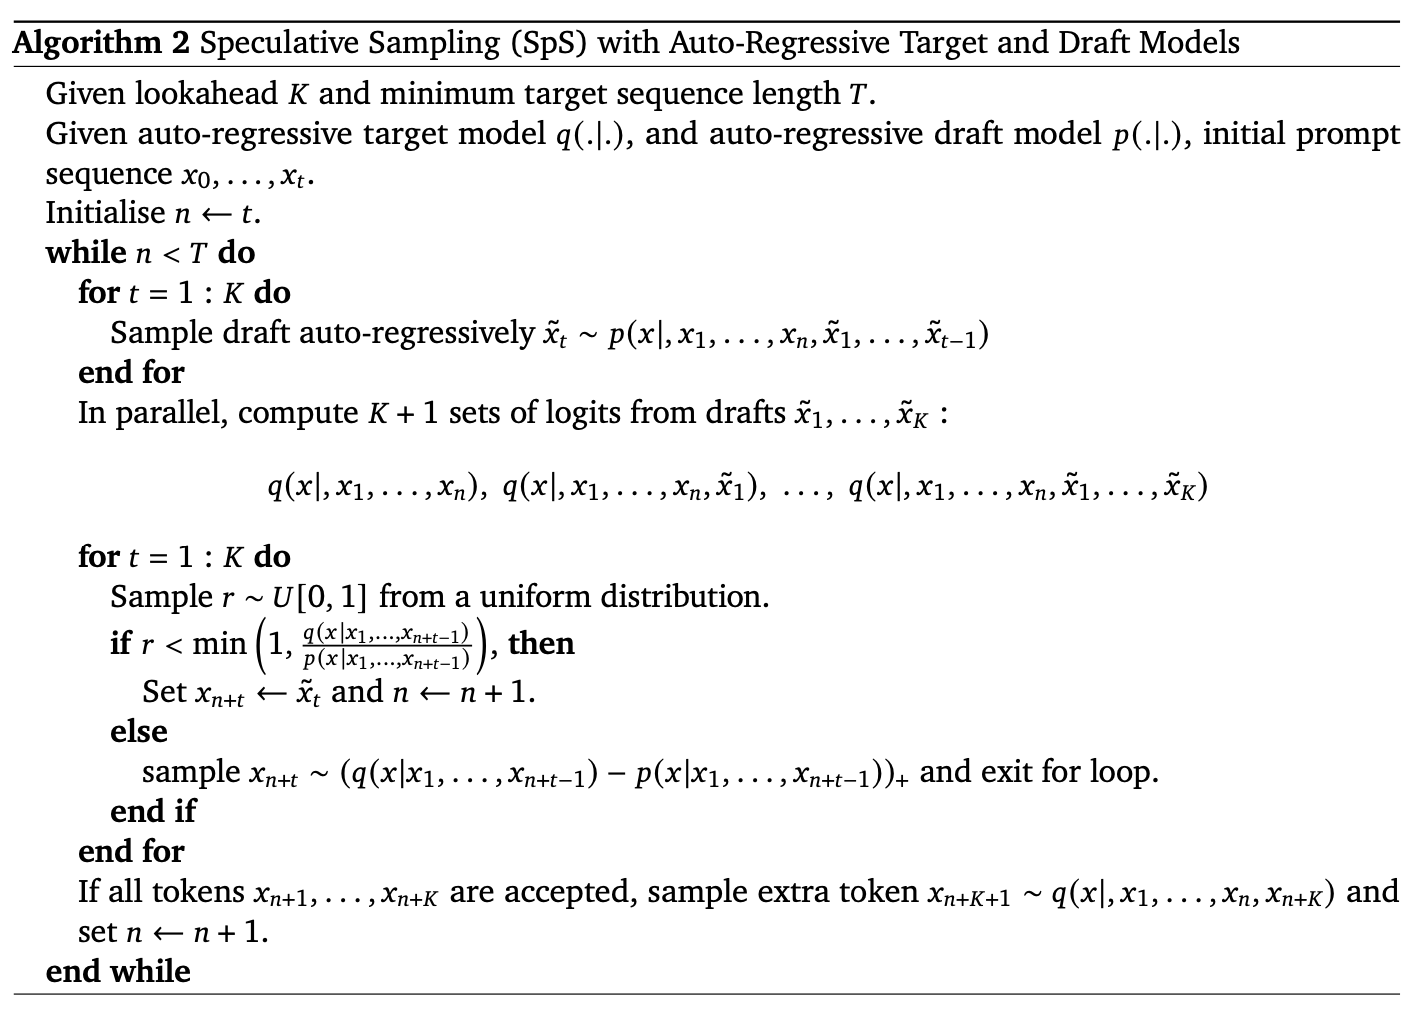

In [4]:
def max_fn(x):
    x_max = torch.where(x > 0, x, 0)
    return x_max / torch.sum(x_max)

In [5]:
def speculative_sampling(x, draft_model, target_model, lookahead_k, max_new_tokens):
    '''p: draft model, q: target model, x: tokenized prompt, K: lookahead_k, N: max_new_tokens'''
    n = len(x[0])
    N = max_new_tokens
    K = lookahead_k
    T = n + N
    
    while n<T:
        draft_input = x
        print('1 draft', draft_input.size())
        for t in range(K): # sample draft-auto-regressively \hat{x}_{(t)}
            p = model_fn(draft_model, draft_input)
            print(draft_input.size())
            print(p.size())
            draft_input =torch.cat((draft_input, sampling(p)), dim =-1)
        # in parallel, compute K+1 logits from the draft \hat{x}_i (i=1,..K)
        
        q = model_fn(target_model, draft_input)
        
        print('q', q.size())
        # add drafted tokens based on rejection algorithm and then resample
        acceptance = True
        for t in range(K):
            print('2 draft', draft_input.size())
            r = np.random.random()
            i = n - 1
            print('i', i)
            drated_token_t = draft_input[0][i+1].reshape(1,-1)
            
            num = q[drated_token_t]
            den = p[drated_token_t]
        
            if r < min(1, num/den):
                print(draft_input)
                print(drated_token_t)
                draft_input = torch.cat((draft_input, drated_token_t), dim=-1)
                n += 1
            else:
                new_sample = sampling(max_fn(q - p))
                draft_input = torch.cat((draft_input, new_sample), dim=-1)
                n += 1
                acceptance = False
                break
        # if all accepted, sample x_{n+K+1} from target model
        if acceptance:
            draft_input = torch.cat((draft_input, sampling(q)), dim=-1)
            n += 1
        return draft_input 

In [6]:
prompt = "The quick brown fox jumps and then he "
max_new_tokens = 50
lookahead_k = 3
# not sure which tokenizer to use 
tokenizer = AutoTokenizer.from_pretrained(checkpoint_target)
x = tokenizer.encode(prompt, return_tensors="pt")

In [7]:
tokenizer.decode(x[0],skip_special_tokens=True)

'The quick brown fox jumps and then he '

In [8]:
draft_model.generate(x, max_length=1, do_sample=True, temperature=.2, return_dict_in_generate=True, output_scores=True).scores[-1][0]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 9, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


tensor([-inf, -inf, -inf,  ..., -inf, -inf, -inf])

In [27]:
def model_fn(model, input_ids, temperature=.6, max_length=1):
    # print(input_ids)
    output = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=temperature, return_dict_in_generate=True, output_scores=True)

    # # Decode the generated ids to text
    # generated_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)

    # The logits of the last token can be obtained from the `scores`
    # which are the logits of the next token predicted after each token of the context
    logits = output.scores[-1][0]  # Last token's logits
    return F.softmax(logits, dim=-1)

In [28]:
torch.sum(model_fn(draft_model, x))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor(1.0000)

In [29]:
output_ar = autoregressive_generation(model = target_model, x= x, max_new_tokens=100)
generated_text = tokenizer.decode(output_ar[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [36]:
print('------------------------------------------')
print(generated_text)

------------------------------------------
The quick brown fox jumps and then he 

gets out of his


In [37]:
print(x[0])

tensor([  464,  2068,  7586, 21831, 18045,   290,   788,   339,   220])


In [42]:
output_sepculative = speculative_sampling(x, draft_model, target_model, lookahead_k=10, max_new_tokens=100)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1 draft torch.Size([1, 9])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

torch.Size([1, 9])
torch.Size([50258])
torch.Size([1, 10])
torch.Size([50258])
torch.Size([1, 11])
torch.Size([50258])
torch.Size([1, 12])
torch.Size([50258])
torch.Size([1, 13])
torch.Size([50258])
torch.Size([1, 14])
torch.Size([50258])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

torch.Size([1, 15])
torch.Size([50258])
torch.Size([1, 16])
torch.Size([50258])
torch.Size([1, 17])
torch.Size([50258])
torch.Size([1, 18])
torch.Size([50258])
q torch.Size([50258])
2 draft torch.Size([1, 19])
i 8
tensor([[  464,  2068,  7586, 21831, 18045,   290,   788,   339,   220,  1849,
         10134,   257,  2612,  1368,    13,  1002,   428,  4325,    11]])
tensor([[1849]])
2 draft torch.Size([1, 20])
i 9
tensor([[  464,  2068,  7586, 21831, 18045,   290,   788,   339,   220,  1849,
         10134,   257,  2612,  1368,    13,  1002,   428,  4325,    11,  1849]])
tensor([[10134]])
2 draft torch.Size([1, 21])
i 10
tensor([[  464,  2068,  7586, 21831, 18045,   290,   788,   339,   220,  1849,
         10134,   257,  2612,  1368,    13,  1002,   428,  4325,    11,  1849,
         10134]])
tensor([[257]])
2 draft torch.Size([1, 22])
i 11
tensor([[  464,  2068,  7586, 21831, 18045,   290,   788,   339,   220,  1849,
         10134,   257,  2612,  1368,    13,  1002,   428,  4325,    1

In [43]:
# Source: [https://jaykmody.com/blog/speculative-sampling/]
output_sepculative.size()

torch.Size([1, 29])

In [44]:
generated_text = tokenizer.decode(output_sepculative[0])

In [45]:
print(generated_text)

The quick brown fox jumps and then he  has a heart attack. If this happens, has a heart attack. If this happens all
